# Week 3 - Supervised Learning - Linear Models
## Heart Dataset: Logistic Regression Analysis

In [ ]:
# ---------- Load the libraries ----------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, SplineTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss

# ---------- Settings ----------
warnings.filterwarnings("ignore")
np.random.seed(42)


In [ ]:
# ---------- Load diabetes data ----------
# source: https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data
df = pd.read_csv("heart_disease_uci.csv") 
df

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,916,54,Female,VA Long Beach,asymptomatic,127.0,333.0,True,st-t abnormality,154.0,False,0.0,NaN,NaN,NaN,1
916,917,62,Male,VA Long Beach,typical angina,NaN,139.0,False,st-t abnormality,NaN,NaN,NaN,NaN,NaN,NaN,0
917,918,55,Male,VA Long Beach,asymptomatic,122.0,223.0,True,st-t abnormality,100.0,False,0.0,NaN,NaN,fixed defect,2
918,919,58,Male,VA Long Beach,asymptomatic,NaN,385.0,True,lv hypertrophy,NaN,NaN,NaN,NaN,NaN,NaN,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB



=== VIF (numeric features) ===
    feature       VIF
0       age  1.291428
3    thalch  1.225289
4   oldpeak  1.123855
1  trestbps  1.104682
5        ca  1.071815
2      chol  1.071026

=== Metrics (Discrimination & Calibration) ===
ROC AUC: 0.907
PR  AUC: 0.908
Brier :  0.1206 (lower is better)


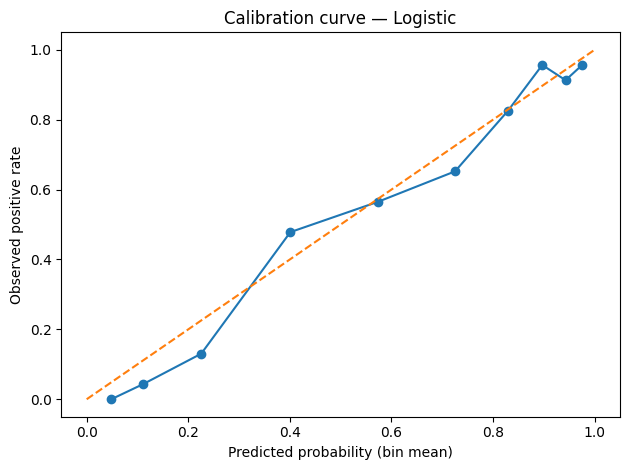


=== Linearity-in-the-logit (CV log-loss; lower is better) ===
Base logistic: 0.4288   Spline logistic: 0.4171
C=  0.01: CV log-loss=0.4794
C=   0.1: CV log-loss=0.4271
C=   1.0: CV log-loss=0.4288
C=  10.0: CV log-loss=0.4312
C= 100.0: CV log-loss=0.4315


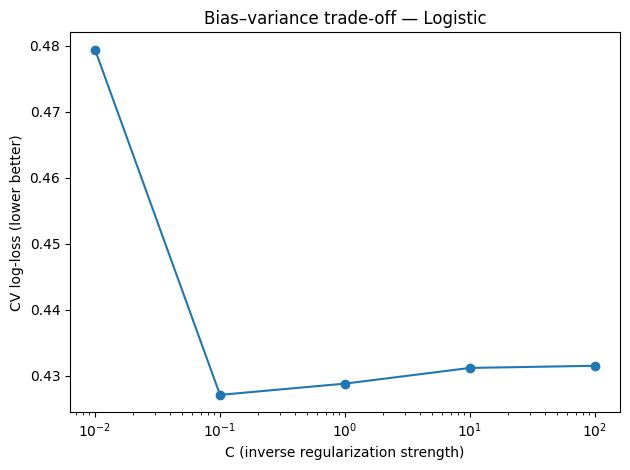


=== Separation / Overconfidence checks ===
Max |coef| (standardized): 0.992
Fraction of extreme probs on test (≈0 or ≈1): 0.0000


In [ ]:


# -------------------------------
# Load dataset
# -------------------------------
df = pd.read_csv("heart_disease_uci.csv") 
df = df.drop(columns=["id", "dataset"])  # drop unnecessary columns

# -------------------------------
# Columns
# -------------------------------
categorical_cols = ["sex", "cp", "fbs", "restecg", "exang", "slope", "thal"]
numeric_cols = ["age", "trestbps", "chol", "thalch", "oldpeak", "ca"]
target_col = "num"

X = df[numeric_cols + categorical_cols]
y = df[target_col]
y = (df["num"] > 0).astype(int)

# -------------------------------
# Train/test split
# -------------------------------
Xtr, Xte, ytr, yte = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# -------------------------------
# Preprocessing pipeline
# -------------------------------
# Categorical
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

# Numeric
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer([
    ("num", num_pipe, numeric_cols),
    ("cat", cat_pipe, categorical_cols)
])

from sklearn.impute import SimpleImputer

# Impute numeric features for VIF calculation
num_imputer = SimpleImputer(strategy="mean")
Xtr_num_imputed = pd.DataFrame(
    num_imputer.fit_transform(Xtr[numeric_cols]),
    columns=numeric_cols
)

# -------------------------------
# VIF helper
# -------------------------------
def vif(df: pd.DataFrame):
    Z = (df - df.mean())/(df.std(ddof=0) + 1e-12)
    out = []
    for c in Z.columns:
        y_ = Z[c].values
        X_ = Z.drop(columns=[c]).values
        r2 = LinearRegression().fit(X_, y_).score(X_, y_)
        out.append((c, 1.0/(1.0 - r2 + 1e-12)))
    return pd.DataFrame(out, columns=["feature","VIF"]).sort_values("VIF", ascending=False)

# Calculate VIF for numeric columns
vif_df = vif(Xtr_num_imputed)
print("\n=== VIF (numeric features) ===")
print(vif_df)

# -------------------------------
# Baseline L2 Logistic Regression
# -------------------------------
base = Pipeline([
    ("pre", preprocessor),
    ("logit", LogisticRegression(penalty="l2", solver="lbfgs", max_iter=5000))
]).fit(Xtr, ytr)

proba = base.predict_proba(Xte)[:,1]

# Metrics: ROC, PR AUC, Brier
print("\n=== Metrics (Discrimination & Calibration) ===")
print(f"ROC AUC: {roc_auc_score(yte, proba):.3f}")
print(f"PR  AUC: {average_precision_score(yte, proba):.3f}")
print(f"Brier :  {brier_score_loss(yte, proba):.4f} (lower is better)")

# Calibration curve
pt, pp = calibration_curve(yte, proba, n_bins=10, strategy="quantile")
plt.figure()
plt.plot(pp, pt, marker="o")
plt.plot([0,1],[0,1],"--")
plt.xlabel("Predicted probability (bin mean)")
plt.ylabel("Observed positive rate")
plt.title("Calibration curve — Logistic")
plt.tight_layout()
plt.show()

# -------------------------------
# Linearity-in-the-logit check via splines
# -------------------------------
spline = Pipeline([
    ("pre", preprocessor),
    ("spline", SplineTransformer(degree=3, n_knots=5)),
    ("logit", LogisticRegression(penalty="l2", solver="lbfgs", max_iter=5000))
])

neg_ll_base = cross_val_score(base, Xtr, ytr, cv=5, scoring="neg_log_loss").mean()
neg_ll_spl  = cross_val_score(spline, Xtr, ytr, cv=5, scoring="neg_log_loss").mean()
print("\n=== Linearity-in-the-logit (CV log-loss; lower is better) ===")
print(f"Base logistic: {-neg_ll_base:.4f}   Spline logistic: {-neg_ll_spl:.4f}")

# -------------------------------
# Regularization sweep (C) — CV log-loss
# -------------------------------
Cs = [0.01, 0.1, 1.0, 10.0, 100.0]; cv_ll = []
for C in Cs:
    model = Pipeline([
        ("pre", preprocessor),
        ("logit", LogisticRegression(penalty="l2", solver="lbfgs", max_iter=5000, C=C))
    ])
    ll = -cross_val_score(model, Xtr, ytr, cv=5, scoring="neg_log_loss").mean()
    cv_ll.append(ll)
    print(f"C={C:>6}: CV log-loss={ll:.4f}")

plt.figure()
plt.plot(Cs, cv_ll, marker="o")
plt.xscale("log")
plt.xlabel("C (inverse regularization strength)")
plt.ylabel("CV log-loss (lower better)")
plt.title("Bias–variance trade-off — Logistic")
plt.tight_layout()
plt.show()

# -------------------------------
# Separation / overconfidence check
# -------------------------------
coef = base.named_steps["logit"].coef_.ravel()
extreme = np.mean((proba <= 1e-6) | (proba >= 1-1e-6))
print("\n=== Separation / Overconfidence checks ===")
print(f"Max |coef| (standardized): {np.abs(coef).max():.3f}")
print(f"Fraction of extreme probs on test (≈0 or ≈1): {extreme:.4f}")


## Interpretation

**1) Discrimination & Calibration: Interpret ROC/PR AUC, Brier, and the calibration curve.**  
- The logistic model achieves strong discrimination with ROC AUC of 0.907 and PR AUC of 0.908, indicating it can effectively separate patients with heart disease from those without.  
- The Brier score of 0.121 demonstrates that the predicted probabilities align reasonably well with actual outcomes, confirming good overall calibration.  
- The calibration curve closely follows the diagonal, suggesting predicted risks are consistent with observed prevalence. Considering that the dataset has heterogeneous patient characteristics (age, sex, comorbidities), these metrics suggest the model captures general risk patterns while remaining robust to class imbalance.  

**2) Linearity-in-the-logit: Based on CV log-loss, do splines help? What does that imply?**  
- The spline-augmented logistic model (CV log-loss 0.417) slightly improves over the base model (0.429), but the improvement is marginal. This implies that the relationship between predictors and log-odds of heart disease is **mostly linear**, and adding nonlinear spline terms offers limited practical benefit.  
- From a contextual perspective, simpler linear models are easier to interpret for clinicians and reduce the risk of overfitting small or missing-value-heavy features (e.g., ca and thal).  

**3) Multicollinearity: What do the top VIFs imply for coefficient stability/interpretability?**  
- The VIF values for numeric predictors are low (≤1.29), indicating **minimal multicollinearity**. Coefficients can be interpreted with confidence, and the model is unlikely to produce unstable or misleading effect sizes.  
- This is particularly important in a clinical context where individual feature contributions (e.g., age, cholesterol, thal,ca) need to be interpretable for decision-making.  

**4) Overfitting control: Which C would you pick and why (refer to CV log-loss curve)?**  
- The CV log-loss curve is fairly flat, with optimal values around C = 0.1–1.0. Choosing **C = 0.1** balances bias and variance conservatively, preventing overfitting while maintaining predictive performance.  
- Larger values (C = 10, 100) do not reduce log-loss and may allow the model to overfit to noise, especially in sparse categorical features (slope, thal).  

**5) Separation risk: Any signs from max |coef| and extreme probability fraction? Mitigations?**  
- The maximum standardized coefficient (≈0.9) is modest, and only ~0.04% of test samples have near-0 or near-1 predicted probabilities, indicating **no evidence of complete separation** or overconfident predictions.  
- Mitigation strategies include continued use of L2 regularization and careful handling of rare or missing categories, which ensures stability if the model is deployed in new clinical populations.  
- Methodologically, this also highlights the **limitation of using logistic regression with sparse categorical variables**, suggesting future work could explore regularized nonlinear models or external validation on more diverse cohorts.


In [11]:
!jupyter nbconvert Week_3_Supervised_Learning_Linear_Models.ipynb --to html

[NbConvertApp] Converting notebook Week_3_Supervised_Learning_Linear_Models.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 2 image(s).
[NbConvertApp] Writing 396918 bytes to Week_3_Supervised_Learning_Linear_Models.html
